In [1]:
!pip install torch==1.4
!pip install torchvision==0.5.0

     |████████████████████████████████| 753.4 MB 5.7 kB/s  eta 0:00:01                | 212.5 MB 56.5 MB/s eta 0:00:10     |███████████▉                    | 279.7 MB 24.8 MB/s eta 0:00:20��▉               | 395.9 MB 41.4 MB/s eta 0:00:09MB/s eta 0:00:16     |███████████████████████████████▉| 750.4 MB 16.8 MB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.6.0
    Uninstalling torch-1.6.0:
      Successfully uninstalled torch-1.6.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

kornia 0.4.1 requires torch>=1.6.0, but you'll have torch 1.4.0 which is incompatible.
fastai 2.0.18 requires torch<1.7,>=1.6, but you'll have torch 1.4.0 which is incompatible.
allennlp 1.2.0 requires torch<1.8.0,>=1.6.0, but you'l

In [2]:
!pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-mt58gbeu
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=273705 sha256=a90a195bce4429f4c37b1e3a49e434e495e3c1fcdd3765dfa5c99761166fdaa8
  Stored in directory: /tmp/pip-ephem-wheel-cache-c_k8t8n6/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import time
import shutil
import torch.nn as nn
from skimage import io
import torchvision
import cv2
import glob
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from albumentations.pytorch import ToTensor
from torchvision import utils
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,Compose, GaussNoise)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
!git clone https://github.com/pytorch/vision.git

Cloning into 'vision'...
remote: Enumerating objects: 11076, done.
remote: Total 11076 (delta 0), reused 0 (delta 0), pack-reused 11076
Receiving objects: 100% (11076/11076), 12.59 MiB | 12.01 MiB/s, done.
Resolving deltas: 100% (7723/7723), done.
fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
cp: cannot stat 'references/detection/utils.py': No such file or directory
cp: cannot stat 'references/detection/transforms.py': No such file or directory
cp: cannot stat 'references/detection/coco_eval.py': No such file or directory
cp: cannot stat 'references/detection/engine.py': No such file or directory
cp: cannot stat 'references/detection/coco_utils.py': No such file or directory


In [8]:
cd vision

/kaggle/working/vision


In [9]:
!git checkout v0.3.0

Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [16]:
!cp references/detection/utils.py ../
!cp references/detection/transforms.py ../
!cp references/detection/coco_eval.py ../
!cp references/detection/engine.py ../
!cp references/detection/coco_utils.py ../

In [17]:
cd ..

/kaggle/working


In [18]:
path_train = "../input/zaloai2020/za_traffic_2020/za_traffic_2020/traffic_train/images"
path_test  = "../input/zaloai2020/za_traffic_2020/za_traffic_2020/traffic_public_test/images/"
path_mask = "../input/mask-traffic-zaloai/mask/"

In [19]:
#load_data
import random
import glob

all_train = glob.glob(path_train+"/*.png")
private_list =  glob.glob(path_test+"*.png")

for idx,img_id in enumerate(all_train):
  all_train[idx] = img_id.split('/')[-1].split('.')[0]

for idx,img_id in enumerate(private_list):
  private_list[idx] = img_id.split('/')[-1].split('.')[0]

random.shuffle(all_train)
ratio_train = 0.7
ratio_valid = 0.2

train_list   = all_train[:int(len(all_train)*ratio_train)]
valid_list   = all_train[int(len(all_train)*ratio_train):int(len(all_train)*(ratio_train+ratio_valid))]
test_list    = all_train[:-int((ratio_train+ratio_valid)*len(all_train))]

In [20]:
df_train = pd.read_csv('../input/zaloai2020/train.csv')

train_df = df_train[df_train['image_id'].isin(train_list)]
val_df = df_train[df_train['image_id'].isin(valid_list)]
test_df = df_train[df_train['image_id'].isin(test_list)]

print ("Train: ",train_df.shape)
print ("Validation: ",val_df.shape)
print ("Test: ",test_df.shape)

Train:  (7715, 9)
Validation:  (2209, 9)
Test:  (1062, 9)


In [21]:
from torchvision import transforms
def get_transforms(phase):
  list_transforms = []
  # if phase == 'train':
  #     list_transforms.extend([Flip(p=0.5)])
  
  list_transforms.extend([ToTensor(),])
  # list_transforms.extend(torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)))
  list_trfms = Compose(list_transforms,bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

  # return transforms.Compose([
  #       # transforms.Grayscale(num_output_channels=1),
  #       # transforms.Resize(input_size),
  #       # transforms.RandomGrayscale(0.1),
  #       transforms.ToTensor(),
  #       transforms.Normalize([0.485,], [0.229,])
  #   ])
  

  return list_trfms

In [33]:
from PIL import Image
import numpy as np
class Traffic_sign(Dataset):
    def __init__(self, data_frame, image_dir, mask_dir, phase='train'):
        
        # super().__init__()
        self.df = data_frame
        self.image_dir = image_dir
        self.images = data_frame['image_id'].unique()
        self.transforms = get_transforms(phase)
        self.mask_dir = mask_dir
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image = str(self.images[idx]) + '.png'
#         image_arr = io.imread(os.path.join(self.image_dir,image))
        
        # image_arr = cv2.imread(os.path.join(self.image_dir,image), cv2.IMREAD_COLOR)
        # image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_arr = Image.open(os.path.join(self.image_dir,image)).convert("RGB")
        image_arr = np.asarray(image_arr)/255
        image_id = int(self.images[idx])
        
        mask = Image.open(os.path.join(self.mask_dir,image))
        mask = np.array(mask)
        
        point = self.df[self.df['image_id'] == image_id]

        boxes = point[['x', 'y', 'w', 'h']].values
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # area = torch.as_tensor(area, dtype=torch.float32)
        
        # there is only one class
        classes = np.asarray(point[['class']].values.reshape(-1).tolist())
        labels = torch.tensor(classes, dtype=torch.int64)
        
        masks = mask == classes[:,None,None]
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        iscrowd = torch.zeros((point.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['masks'] = masks
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image_arr,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']
        
        target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        
        return image, target

In [34]:
train_data = Traffic_sign(train_df, path_train, path_mask, phase='train')
val_data = Traffic_sign(val_df, path_train, path_mask, phase='validation')
test_data = Traffic_sign(test_df, path_train, path_mask, phase='test')

In [35]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=False,
    num_workers=8,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    val_data,
    batch_size=8,
    shuffle=False,
    num_workers=8,
    collate_fn=collate_fn
)

test_data_loader = DataLoader(
    test_data,
    batch_size=8,
    shuffle=False,
    num_workers=8,
    collate_fn=collate_fn
)

In [36]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data,idx):
    out = data.__getitem__(idx)
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    bb = out[1]['boxes'].numpy()
    for i in bb:
        cv2.rectangle(image, (i[0],i[1]), (i[2],i[3]), (0,255,0),2)
    plt.figure(figsize=(10,10))
    plt.imshow(image)

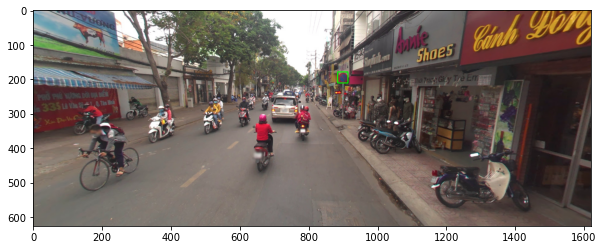

In [37]:
plot_img(train_data,10)

In [38]:
train_data.__getitem__(22)

(tensor([[[0.4627, 0.4627, 0.4627,  ..., 0.7294, 0.7647, 0.8118],
          [0.4627, 0.4627, 0.4627,  ..., 0.7608, 0.8078, 0.8314],
          [0.4627, 0.4627, 0.4627,  ..., 0.7961, 0.8196, 0.8353],
          ...,
          [0.8863, 0.8902, 0.8941,  ..., 0.3686, 0.3922, 0.4235],
          [0.9020, 0.9020, 0.9098,  ..., 0.3451, 0.3686, 0.4000],
          [0.9176, 0.9216, 0.9294,  ..., 0.3294, 0.3490, 0.3725]],
 
         [[0.4000, 0.4000, 0.4000,  ..., 0.7176, 0.7529, 0.7961],
          [0.4000, 0.4000, 0.4000,  ..., 0.7490, 0.7922, 0.8118],
          [0.4000, 0.4000, 0.4000,  ..., 0.7804, 0.8039, 0.8157],
          ...,
          [0.8902, 0.8941, 0.8980,  ..., 0.3529, 0.3765, 0.4078],
          [0.9059, 0.9059, 0.9137,  ..., 0.3294, 0.3529, 0.3843],
          [0.9216, 0.9255, 0.9333,  ..., 0.3137, 0.3333, 0.3569]],
 
         [[0.3020, 0.3020, 0.3020,  ..., 0.6824, 0.7176, 0.7647],
          [0.3020, 0.3020, 0.3020,  ..., 0.7137, 0.7569, 0.7765],
          [0.3020, 0.3020, 0.3020,  ...,

In [45]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Stop here if you are fine-tunning Faster-RCNN

#     now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [46]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 8

# get the model using our helper function
model = build_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
from engine import train_one_epoch, evaluate
num_epochs = 10


for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, valid_data_loader, device=device)

In [ ]:
# import math
# import sys
# import time
# import torch

# import torchvision.models.detection.mask_rcnn

# from coco_utils import get_coco_api_from_dataset
# from coco_eval import CocoEvaluator
# import utils

# train_loss=[]
# total_train_loss = []
# def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
#     model.train()
#     metric_logger = utils.MetricLogger(delimiter="  ")
#     metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
#     header = 'Epoch: [{}]'.format(epoch)

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1. / 1000
#         warmup_iters = min(1000, len(data_loader) - 1)

#         lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

#     for images, targets in metric_logger.log_every(data_loader, print_freq, header):
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         loss_dict = model(images, targets)

#         losses = sum(loss for loss in loss_dict.values())
#         train_loss.append(losses.item())
#         # reduce losses over all GPUs for logging purposes
#         loss_dict_reduced = utils.reduce_dict(loss_dict)
#         losses_reduced = sum(loss for loss in loss_dict_reduced.values())

#         loss_value = losses_reduced.item()

#         if not math.isfinite(loss_value):
#             print("Loss is {}, stopping training".format(loss_value))
#             print(loss_dict_reduced)
#             sys.exit(1)

#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step()

#         metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
#         metric_logger.update(lr=optimizer.param_groups[0]["lr"])
#     epoch_train_loss = np.mean(train_loss)
#     total_train_loss.append(epoch_train_loss)
#     return metric_logger

In [ ]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)

In [ ]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# num_classes =  2 # 1 class (wheat) + background

# # get number of input features for the classifier
# in_features = model.roi_heads.box_predictor.cls_score.in_features

# # replace the pre-trained head with a new one
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# model.to(device)
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0005)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                step_size=3,
#                                                gamma=0.1)

# # num_classes = 8  # 1 class (wheat) + background

# # # get number of input features for the classifier
# # in_features = model.roi_heads.box_predictor.cls_score.in_features

# # # replace the pre-trained head with a new one
# # model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# # model.to(device)
# # params = [p for p in model.parameters() if p.requires_grad]
# # optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
# #                                                step_size=3,
# #                                                gamma=0.1)

In [ ]:
# from engine import evaluate
# num_epochs = 500

# for epoch in range(num_epochs):
#     # train for one epoch, printing every 10 iterations
#     train_one_epoch(model, optimizer,train_data_loader, device, epoch, print_freq=10)
#     # update the learning rate
#     lr_scheduler.step()
#     # evaluate on the valid dataset
#     evaluate(model, valid_data_loader, device=device)